In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

from spineq.data_fetcher import get_oa_shapes, get_oa_centroids, get_la_shape
from spineq.plotting import plot_oa_weights, get_color_axis, plot_optimisation_result
from spineq.greedy import greedy_opt
from spineq.optimise import make_result_dict
from spineq.utils import coverage_matrix

import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

## Space Syntax

In [2]:
ss = gpd.read_file("../data/raw/space_syntax/TyneandWear_geojson.geojson")
ss

,fid,id,metres,meridian_road_name,choice2km,choice2kmrank,choice2kmlog,nodecount2km,integration2km,integration2kmrank,...,AI_,AI__N,AI__TD,AI__MD,AC_,AC__NACH,AC__N,AC__TD,AC__MD,geometry
0,152060,715451,177.496479,CHESTER ROAD,160.0,0.176370,2.206826,95.0,35.554872,0.121575,...,0.088330,63458,7.184104e+05,11.321217,1.128356e+07,1.185581,63458,8.882088e+05,13.997019,"LINESTRING (428738.000 552012.000, 428865.000 ..."
1,152061,715452,366.152973,CHESTER ROAD,96.0,0.151203,1.986772,74.0,28.724683,0.094502,...,0.087621,63458,7.242230e+05,11.412815,1.118910e+07,1.184374,63458,8.943179e+05,14.093290,"LINESTRING (428865.000 551888.000, 429173.000 ..."
2,152062,715453,475.231523,CHESTER ROAD,108.0,0.159919,2.037426,72.0,26.341029,0.076923,...,0.086980,63458,7.295599e+05,11.496918,1.109785e+07,1.183276,63458,8.995236e+05,14.175324,"LINESTRING (429173.000 551690.000, 429612.000 ..."
3,152063,715454,393.640699,CHESTER ROAD,194.0,0.233983,2.290035,81.0,23.248390,0.066852,...,0.086527,63458,7.333755e+05,11.557047,1.100970e+07,1.182134,63458,9.053866e+05,14.267719,"LINESTRING (429612.000 551508.000, 429999.000 ..."
4,256244,820413,24.020824,None,527.0,0.421875,2.722634,115.0,32.694522,0.292969,...,0.081439,63458,7.791924e+05,12.279061,4.026128e+05,0.937454,63458,9.524389e+05,15.009201,"LINESTRING (430000.000 551412.000, 429999.000 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63453,1934282,432474,185.585560,GARSDALE ROAD,14.0,0.078462,1.176091,265.0,59.193867,0.204615,...,0.061632,63458,1.029617e+06,16.225422,8.000000e+00,0.156033,63458,1.305086e+06,20.566466,"LINESTRING (434402.000 574229.000, 434581.000 ..."
63454,1934312,432503,101.390335,ST CHAD'S ROAD,4393.0,0.721616,3.642860,405.0,99.508184,0.628821,...,0.087423,63458,7.258648e+05,11.438687,3.418600e+05,0.928995,63458,9.053429e+05,14.267030,"LINESTRING (435905.000 553310.000, 435999.000 ..."
63455,1934313,432504,279.379670,None,34193.0,0.996528,4.533950,521.0,139.692011,0.983796,...,0.091125,63458,6.963749e+05,10.973966,6.797834e+07,1.317488,63458,8.809020e+05,13.881873,"LINESTRING (431020.000 571134.000, 431222.000 ..."
63456,1934314,432505,183.251194,None,16602.0,0.939394,4.220187,497.0,136.727754,0.975524,...,0.091124,63458,6.963824e+05,10.974083,6.425634e+07,1.313133,63458,8.831198e+05,13.916823,"LINESTRING (431222.000 571327.000, 431347.000 ..."


In [3]:
# only keep space syntax segments intersecting or within local authority geometry
la = get_la_shape()

ss = ss[
    ss.crosses(la.geometry)
    | ss.within(la.geometry)
]

Text(0.5, 1.0, 'AC__NACH')

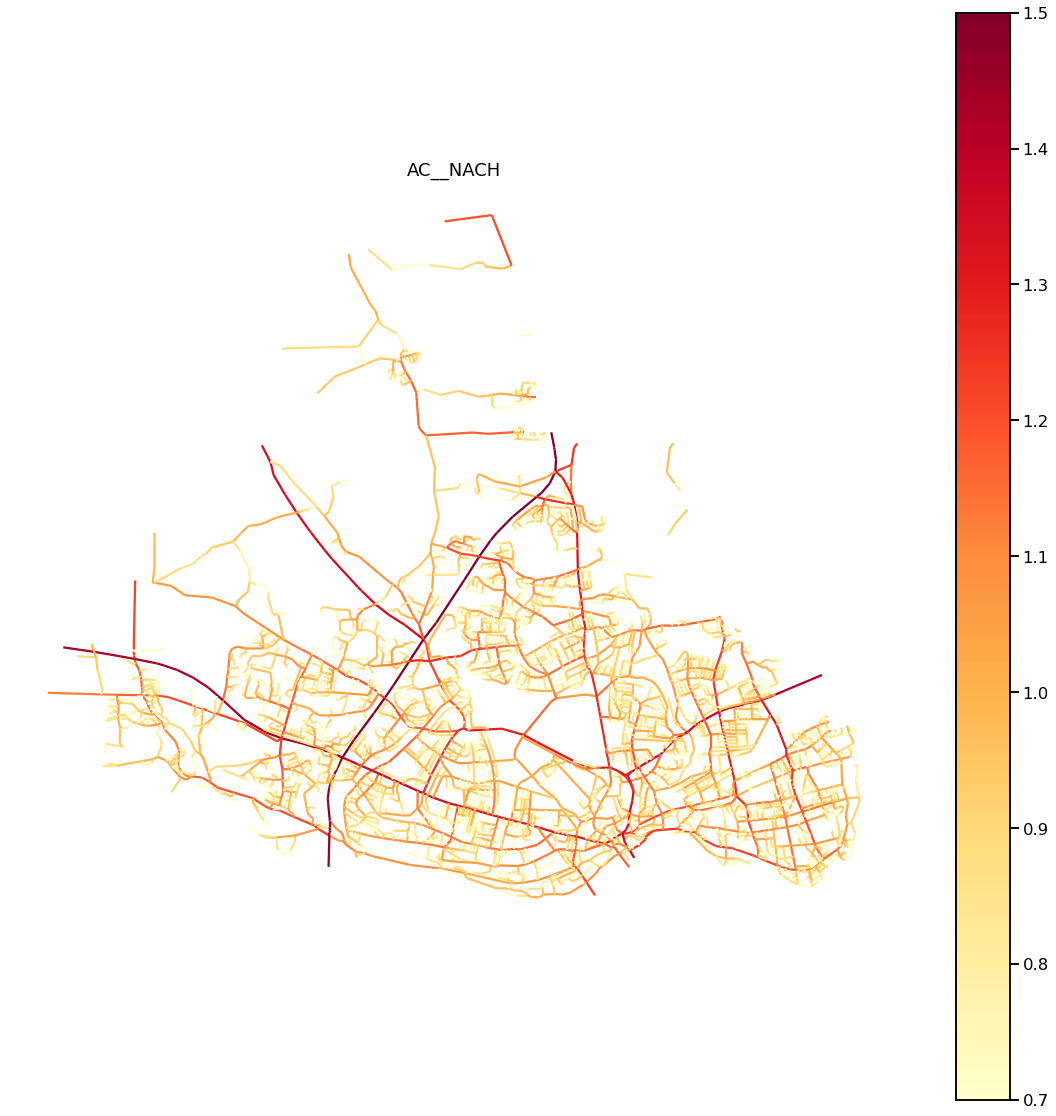

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(column="AC__NACH", ax=ax, cmap="YlOrRd", legend=True, vmin=0.7, vmax=1.5)
ax.axis("off")
ax.set_title("AC__NACH")

<AxesSubplot:ylabel='Frequency'>

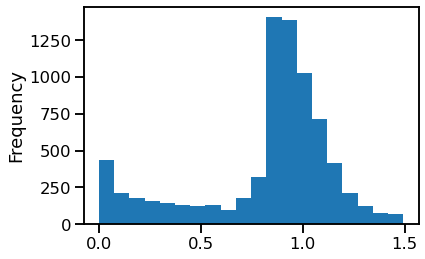

In [5]:
ss["AC__NACH"].plot.hist(bins=20)

## Raw DFT Traffic Data

In [6]:
dft = pd.read_csv("../data/raw/raw_dft_data/dft_aadf_local_authority_id_172.csv")
dft.head()

,count_point_id,year,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,46650,2019,11,North East,172,Newcastle upon Tyne,A191,Major,A1(T)/A69,B1311,...,93,1063,77,9,16,0,1,2,104,8358
1,6745,2019,11,North East,172,Newcastle upon Tyne,A193,Major,A193/A167(M),A193,...,76,2959,157,26,17,9,20,12,240,21292
2,6740,2019,11,North East,172,Newcastle upon Tyne,A191,Major,A189,A188,...,174,1843,80,8,9,3,3,9,113,14107
3,38720,2019,11,North East,172,Newcastle upon Tyne,A1,Major,Kingston Park Road roundabout,A1056 North Brunton,...,140,12151,1075,236,450,119,906,947,3733,85837
4,37534,2019,11,North East,172,Newcastle upon Tyne,A186,Major,Clayton St West,Collingwood St,...,777,587,83,12,5,7,5,5,116,6864


In [7]:
select_year = 2019
dft = dft[dft["year"] == select_year]
dft.head()

,count_point_id,year,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,46650,2019,11,North East,172,Newcastle upon Tyne,A191,Major,A1(T)/A69,B1311,...,93,1063,77,9,16,0,1,2,104,8358
1,6745,2019,11,North East,172,Newcastle upon Tyne,A193,Major,A193/A167(M),A193,...,76,2959,157,26,17,9,20,12,240,21292
2,6740,2019,11,North East,172,Newcastle upon Tyne,A191,Major,A189,A188,...,174,1843,80,8,9,3,3,9,113,14107
3,38720,2019,11,North East,172,Newcastle upon Tyne,A1,Major,Kingston Park Road roundabout,A1056 North Brunton,...,140,12151,1075,236,450,119,906,947,3733,85837
4,37534,2019,11,North East,172,Newcastle upon Tyne,A186,Major,Clayton St West,Collingwood St,...,777,587,83,12,5,7,5,5,116,6864


In [8]:
len(dft)

137

In [9]:
dft = gpd.GeoDataFrame(dft, geometry=gpd.points_from_xy(dft["easting"], dft["northing"]),  crs="epsg:27700")

Text(0.5, 1.0, 'DfT Traffic Count Points')

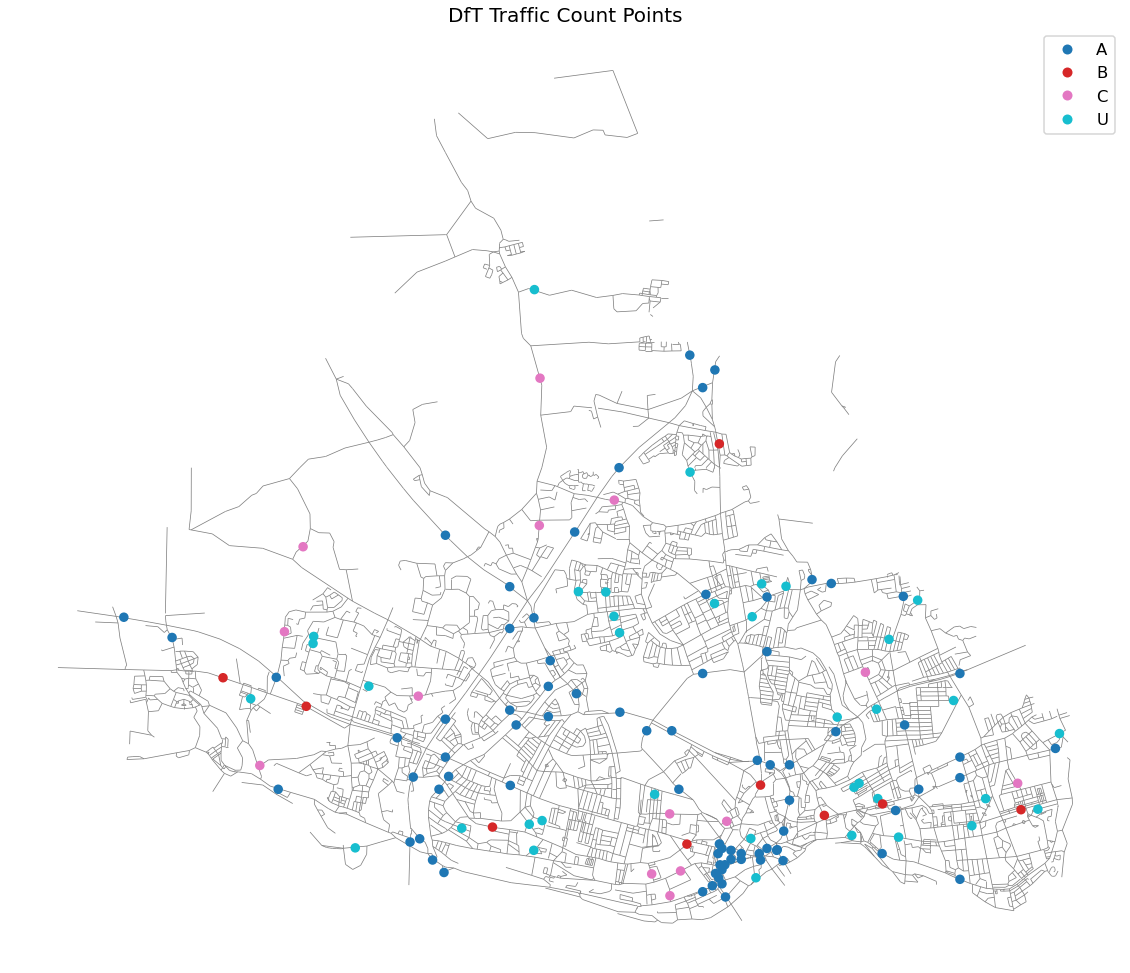

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(ax=ax, zorder=1, color="gray", linewidth=0.75)
dft.plot(ax=ax, markersize=64, column=dft["road_name"].str[0], zorder=2, legend=True)
ax.axis("off")
ax.set_title("DfT Traffic Count Points", fontsize=20)

### Snap DFT points to nearest  lines (roads) in space syntax model

Following approach from:
- https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa


In [11]:
def match_dft_ss(
    dft: pd.DataFrame, ss: gpd.GeoDataFrame, offset: float = 10, tolerance: float = 50
) -> gpd.GeoDataFrame:
    """
    Find the line segments in the space syntax data ss that are closest to the
    traffic measurement points in dft.

    Inspired by https://medium.com/@brendan_ward/6113c94e59aa
    """
    ss.sindex  # Create spatial index (makes computation faster later)

    # all space syntax (ss) segments that intersect DfT measurement points
    # (within offset metres east/north of measurement point):
    bbox = dft.bounds + [-offset, -offset, offset, offset]
    hits = bbox.apply(lambda row: list(ss.sindex.intersection(row)), axis=1)

    # convert hits to flat list (row cotaining list of matches, to rows each
    # containing 1 match)
    hits = pd.DataFrame(
        {
            # index of point in dft
            "pt_idx": np.repeat(hits.index, hits.apply(len)),
            # index of line segment in ss
            "line_idx": np.concatenate(hits.values),
        }
    )

    # Join ss and dft based on matched indices
    hits = hits.join(ss.reset_index(drop=True), on="line_idx")
    hits = hits.join(dft.rename(columns={"geometry": "point"}), on="pt_idx")
    hits = gpd.GeoDataFrame(hits, geometry="geometry", crs=dft.crs)

    # calculate distances between points and matched line segments
    hits["snap_dist"] = hits.geometry.distance(gpd.GeoSeries(hits.point))
    # discard any hits with more than tolerance metres between dft point
    # and ss segment
    hits = hits.loc[hits.snap_dist <= tolerance]

    # Select closest dft point and ss segment match
    hits = hits.sort_values(by=["snap_dist"])
    closest = hits.groupby("pt_idx").first()

    return gpd.GeoDataFrame(closest, geometry="geometry")

In [12]:
dft_ss = match_dft_ss(dft, ss)
dft_ss.head()

,line_idx,fid,id,metres,meridian_road_name,choice2km,choice2kmrank,choice2kmlog,nodecount2km,integration2km,...,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,point,snap_dist
pt_idx,,,,,,,,,,,,,,,,,,,,,
0,7212.0,513379,1078911,210.793738,DENTON ROAD,16277.333008,0.889610,4.211610,557.0,175.913927,...,77,9,16,0,1,2,104,8358,POINT (419900.000 565000.000),5.166188
1,5520.0,424870,990347,417.731971,CONYERS ROAD,21774.166016,0.791721,4.337961,928.0,255.911117,...,157,26,17,9,20,12,240,21292,POINT (427000.000 564670.000),4.452616
2,3767.0,419905,985383,193.041446,BENTON PARK ROAD,8534.000000,0.721905,3.931204,545.0,153.732504,...,80,8,9,3,3,9,113,14107,POINT (426000.000 568200.000),0.616448
3,2878.0,417067,982545,176.181724,None,770.000000,0.361261,2.887054,378.0,87.592313,...,1075,236,450,119,906,947,3733,85837,POINT (422700.000 570000.000),0.771930
4,2384.0,413601,979087,117.953381,NEVILLE STREET,2056.000000,0.323359,3.313234,1011.0,241.067315,...,83,12,5,7,5,5,116,6864,POINT (424600.000 563910.000),5.536085


<AxesSubplot:title={'center':'Space Syntax Segments with DfT Measurement'}>

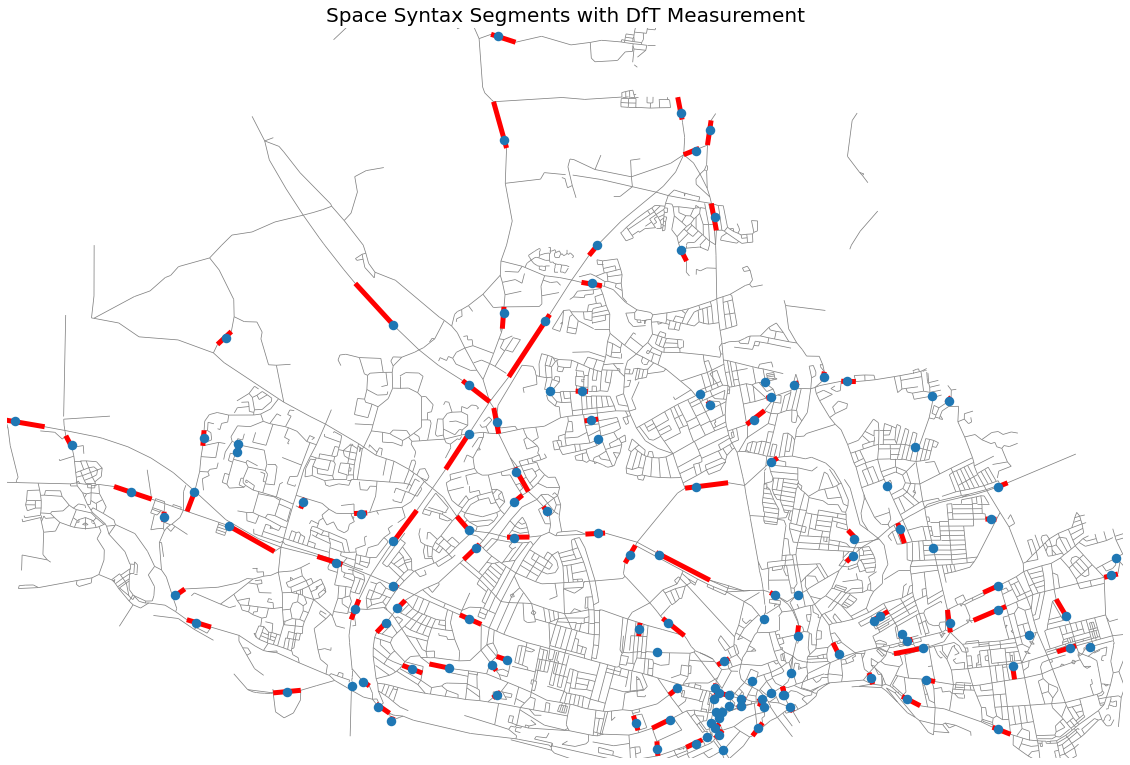

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(ax=ax, zorder=1, linewidth=0.75, color="gray")
dft_ss.plot(ax=ax, zorder=2, color="r", linewidth=5)
ax.axis("off")
ax.set_title("Space Syntax Segments with DfT Measurement", fontsize=20)
border = 100
ax.set_xlim([dft["easting"].min() - border, dft["easting"].max() + border])
ax.set_ylim([dft["northing"].min() - border, dft["northing"].max() + border])
dft_ss["point"].plot(ax=ax, markersize=64, zorder=3)


Text(0, 0.5, 'log[all_motor_vehicles]')

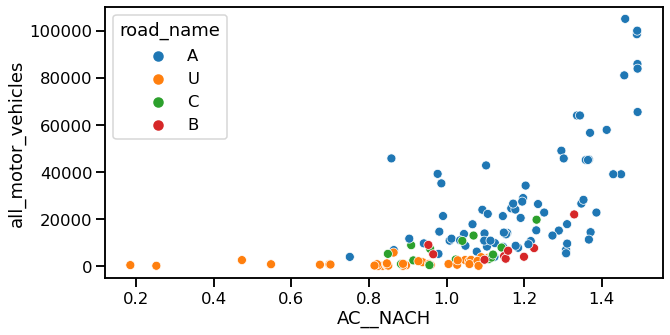

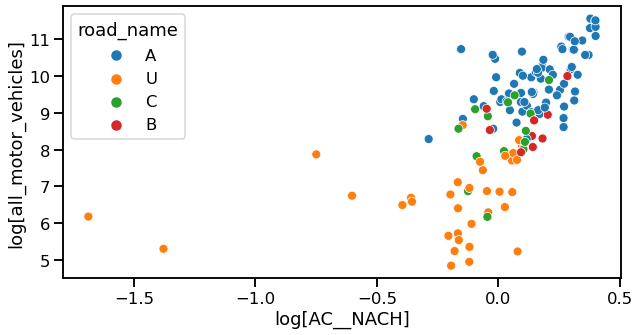

In [14]:
column = "AC__NACH"

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=dft_ss[column], y=dft_ss["all_motor_vehicles"], hue=dft_ss["road_name"].str[0]
)

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=np.log(dft_ss[column]),
    y=np.log(dft_ss["all_motor_vehicles"]),
    hue=dft_ss["road_name"].str[0],
)
plt.xlabel(f"log[{column}]")
plt.ylabel("log[all_motor_vehicles]")

In [15]:
print(np.corrcoef(dft_ss["AC__NACH"], dft_ss["all_motor_vehicles"]))
spearmanr(dft_ss["AC__NACH"], dft_ss["all_motor_vehicles"])

[[1.         0.63738414]
 [0.63738414 1.        ]]


SpearmanrResult(correlation=0.746503567475372, pvalue=1.7927221507247356e-25)

8.620081815759415 [3.77147764]


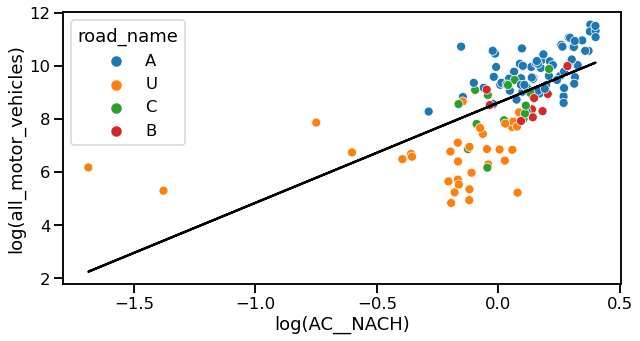

In [16]:
X = np.log(dft_ss["AC__NACH"]).values
y = np.log(dft_ss["all_motor_vehicles"])

mdl = LinearRegression()
mdl.fit(X.reshape(-1, 1), y)
print(mdl.intercept_, mdl.coef_)

y_pred = mdl.predict(X.reshape(-1, 1))
plt.figure(figsize=(10, 5))
plt.plot(X, y_pred, "k")
sns.scatterplot(x=X, y=y, hue=dft_ss["road_name"].str[0])
plt.xlabel("log(AC__NACH)")
plt.ylabel("log(all_motor_vehicles)")

resid = y_pred - y
dft_ss["resid"] = resid
dft_ss["pred"] = np.exp(y_pred)


In [17]:
dft_ss["abs_resid"] = dft_ss["resid"].abs()

print("PRED (SYNTAX) > ACTUAL (DFT)")
display(dft_ss.sort_values(by="resid", ascending=False)[
    ["road_name", "road_type", "all_motor_vehicles", "pred", "resid"]
].head(15))

print("PRED (SYNTAX) < ACTUAL (DFT)")
display(dft_ss.sort_values(by="resid", ascending=True)[
    ["road_name", "road_type", "all_motor_vehicles", "pred", "resid"]
].head(15))

PRED (SYNTAX) > ACTUAL (DFT)


,road_name,road_type,all_motor_vehicles,pred,resid
pt_idx,,,,,
509,U,Minor,187,7470.339774,3.687587
433,U,Minor,141,3528.591555,3.219894
123,U,Minor,127,2662.532245,3.042846
510,U,Minor,212,3538.660485,2.814917
122,U,Minor,189,2809.956148,2.699177
419,U,Minor,254,2999.823728,2.468975
200,U,Minor,625,6131.581915,2.283456
486,C,Minor,479,4674.424419,2.278161
400,U,Minor,306,2955.609157,2.267875


PRED (SYNTAX) < ACTUAL (DFT)


,road_name,road_type,all_motor_vehicles,pred,resid
pt_idx,,,,,
523,U,Minor,483,9.522487,-3.926361
1891,A695,Major,45770,3107.868113,-2.689692
410,U,Minor,2618,327.889171,-2.077490
2212,A189,Major,39208,5075.952547,-2.044367
11,A69,Major,35175,5266.325406,-1.899003
126,U,Minor,201,30.584162,-1.882823
101,A191,Major,42793,7990.158266,-1.678164
6,A1,Major,104999,23121.367420,-1.513194
115,A1,Major,99984,25022.241524,-1.385245


(413186.25, 430538.75, 562255.05, 576839.95)

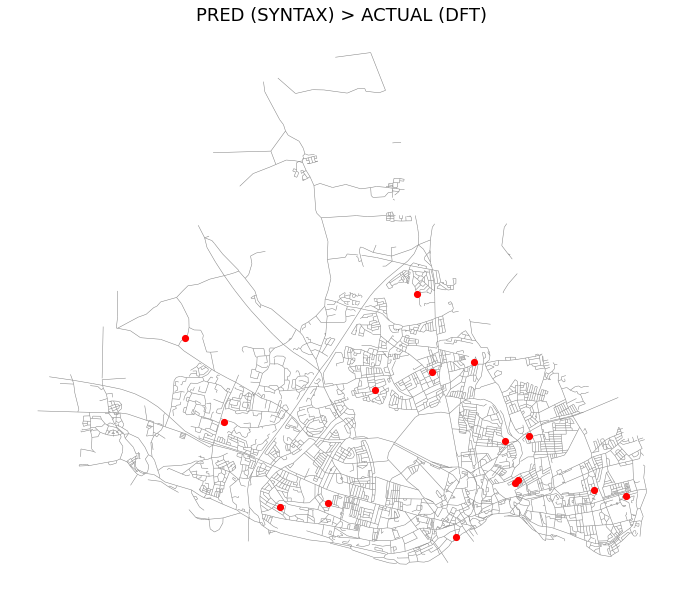

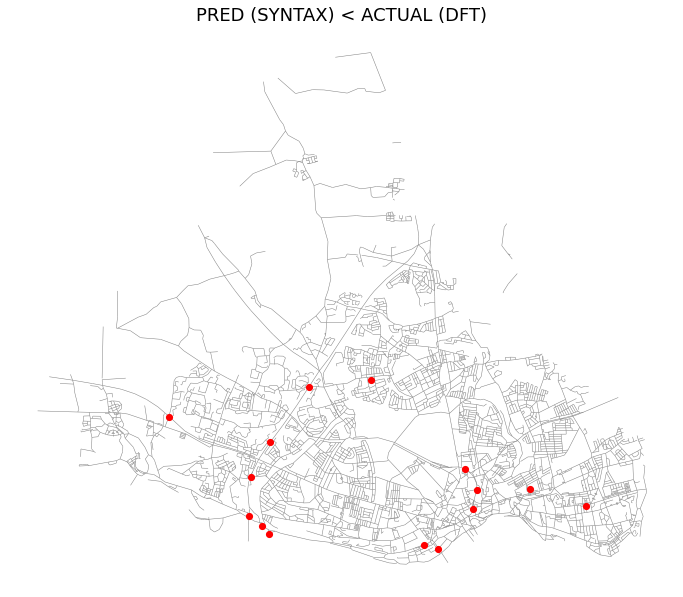

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ss.plot(ax=ax, zorder=1, linewidth=0.5, color="gray")
dft_ss.sort_values(by="resid", ascending=False).head(15)["point"].plot(
    ax=ax, zorder=2, color="r", markersize=32
)
ax.set_title("PRED (SYNTAX) > ACTUAL (DFT)")
ax.axis("off")

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ss.plot(ax=ax, zorder=1, linewidth=0.5, color="gray")
dft_ss.sort_values(by="resid", ascending=True).head(15)["point"].plot(
    ax=ax, zorder=2, color="r", markersize=32
)
ax.set_title("PRED (SYNTAX) < ACTUAL (DFT)")
ax.axis("off")

## Max Space Syntax in Output Area

In [19]:
oa = get_oa_shapes()
oa

,geometry
oa11cd,
E00042042,"POLYGON ((421176.250 564469.753, 421177.231 56..."
E00042043,"POLYGON ((420510.000 564944.000, 420572.364 56..."
E00042044,"POLYGON ((420365.325 564561.637, 420438.986 56..."
E00042045,"POLYGON ((421543.715 563955.116, 421503.886 56..."
E00042046,"POLYGON ((422200.279 563353.233, 422078.508 56..."
...,...
E00175601,"POLYGON ((427400.000 567000.000, 427394.570 56..."
E00175602,"POLYGON ((421527.683 567236.668, 421490.250 56..."
E00175603,"POLYGON ((421600.722 567070.861, 421562.614 56..."


<AxesSubplot:>

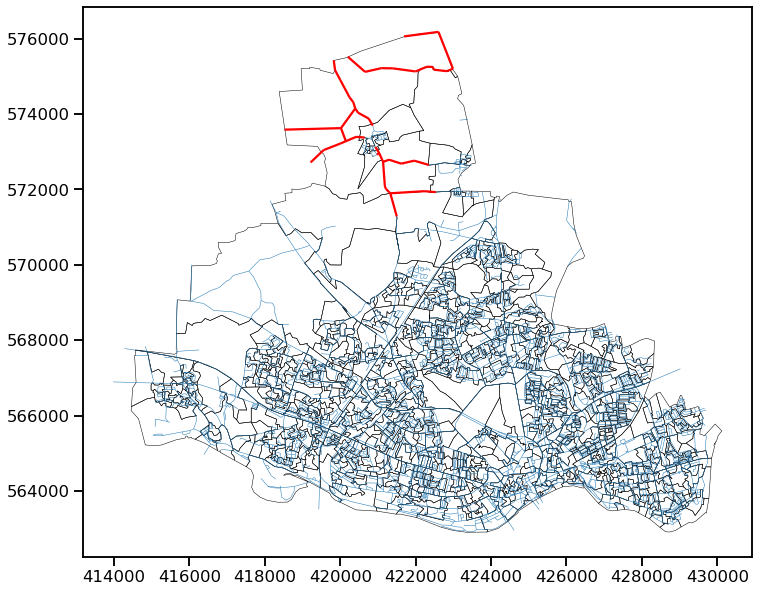

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
oa["select"] = False
oa.loc["E00042162", "select"] = True
#oa.plot(column="select", ax=ax)
oa.plot(color="None", ax=ax, linewidth=0.5)
ss.plot(ax=ax, linewidth=0.5)
ss[
    ss.crosses(oa.loc["E00042162", "geometry"])
    | ss.within(oa.loc["E00042162", "geometry"])
].plot(color="r", ax=ax)

In [21]:
oa["AC__NACH_max"] = [
    ss[
        ss.crosses(oa.loc[oa_name, "geometry"]) | ss.within(oa.loc[oa_name, "geometry"])
    ]["AC__NACH"].max()
    for oa_name in oa.index
]
oa["AC__NACH_max"].fillna(1e-6, inplace=True)
oa["AC__NACH_max"]

oa11cd
E00042042    1.111490
E00042043    0.890865
E00042044    1.021795
E00042045    0.894019
E00042046    1.042340
               ...   
E00175601    1.157726
E00175602    1.214076
E00175603    1.202127
E00175604    0.848616
E00175605    1.492384
Name: AC__NACH_max, Length: 910, dtype: float64

In [35]:
oa_segments = [
    (ss.crosses(oa.loc[oa_name, "geometry"]) | ss.within(oa.loc[oa_name, "geometry"])).sum()
    for oa_name in oa.index
]

In [36]:
oa_segments = pd.Series(oa_segments, index=oa.index)
oa_segments.describe()

count    910.000000
mean      12.256044
std        9.239947
min        0.000000
25%        7.000000
50%       10.000000
75%       16.000000
max       81.000000
dtype: float64

<AxesSubplot:ylabel='Proportion'>

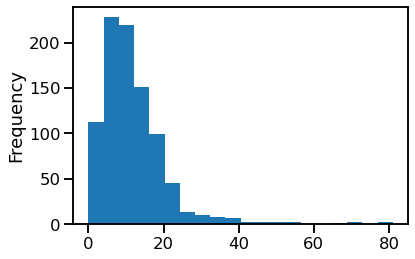

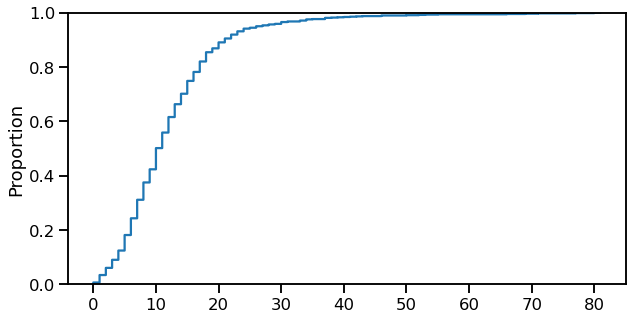

In [45]:
# how many space syntax segments in each oa
oa_segments.plot.hist(bins=20)

plt.figure(figsize=(10, 5))
import seaborn as sns
sns.ecdfplot(oa_segments)

In [22]:
# fix log(NaN) and log(0)
oa["AC__NACH_max"].fillna(1e-6, inplace=True)
oa["AC__NACH_max"].replace(0, 1e-6, inplace=True)

oa["traffic_max"] = np.exp(mdl.predict(np.log(oa["AC__NACH_max"]).values.reshape(-1, 1)))
oa

,geometry,select,AC__NACH_max,traffic_max
oa11cd,,,,
E00042042,"POLYGON ((421176.250 564469.753, 421177.231 56...",False,1.111490,8256.312567
E00042043,"POLYGON ((420510.000 564944.000, 420572.364 56...",False,0.890865,3584.026867
E00042044,"POLYGON ((420365.325 564561.637, 420438.986 56...",False,1.021795,6011.320117
E00042045,"POLYGON ((421543.715 563955.116, 421503.886 56...",False,0.894019,3632.119219
E00042046,"POLYGON ((422200.279 563353.233, 422078.508 56...",False,1.042340,6480.024631
...,...,...,...,...
E00175601,"POLYGON ((427400.000 567000.000, 427394.570 56...",False,1.157726,9628.123886
E00175602,"POLYGON ((421527.683 567236.668, 421490.250 56...",False,1.214076,11518.230753
E00175603,"POLYGON ((421600.722 567070.861, 421562.614 56...",False,1.202127,11096.475649


In [23]:
oa["AC__NACH_max"].describe()

count    910.000000
mean       1.106226
std        0.190452
min        0.000001
25%        1.012113
50%        1.105701
75%        1.200312
max        1.492384
Name: AC__NACH_max, dtype: float64

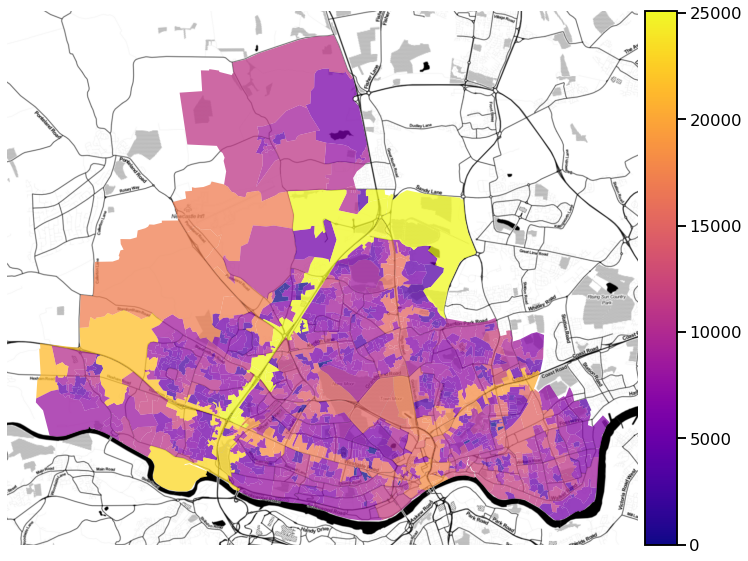

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
lad20cd = "E08000021"
plot_oa_weights(
    lad20cd,
    oa["traffic_max"],
    vmin=0,
    vmax=None,
    ax=ax
)


In [25]:
centroids = get_oa_centroids()
oa = oa.join(centroids)
theta = 500
cm =  coverage_matrix(oa["x"], oa["y"], theta=theta)

In [26]:
n_sensors = 20
r = greedy_opt(n_sensors, cm, oa["traffic_max"].values)

r = make_result_dict(
    lad20cd,
    n_sensors,
    theta,
    oa["x"].values,
    oa["y"].values,
    oa.index,
    r["sensors"],
    r["total_coverage"],
    r["point_coverage"],
    list(oa.index[r["placement_history"]]),
    r["coverage_history"],
    oa_weight=r["weights"],
    pop_age_groups={},
    population_weight=0,
    workplace_weight=0,
)

Placing sensor 1 out of 20 ... coverage = 0.03
Placing sensor 2 out of 20 ... coverage = 0.07
Placing sensor 3 out of 20 ... coverage = 0.10
Placing sensor 4 out of 20 ... coverage = 0.12
Placing sensor 5 out of 20 ... coverage = 0.14
Placing sensor 6 out of 20 ... coverage = 0.16
Placing sensor 7 out of 20 ... coverage = 0.18
Placing sensor 8 out of 20 ... coverage = 0.20
Placing sensor 9 out of 20 ... coverage = 0.22
Placing sensor 10 out of 20 ... coverage = 0.23
Placing sensor 11 out of 20 ... coverage = 0.24
Placing sensor 12 out of 20 ... coverage = 0.25
Placing sensor 13 out of 20 ... coverage = 0.27
Placing sensor 14 out of 20 ... coverage = 0.28
Placing sensor 15 out of 20 ... coverage = 0.29
Placing sensor 16 out of 20 ... coverage = 0.30
Placing sensor 17 out of 20 ... coverage = 0.31
Placing sensor 18 out of 20 ... coverage = 0.32
Placing sensor 19 out of 20 ... coverage = 0.32
Placing sensor 20 out of 20 ... coverage = 0.33


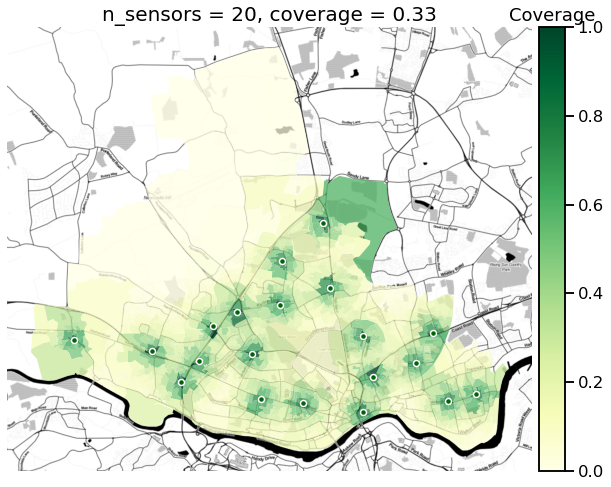

In [27]:
plot_optimisation_result(r)

In [50]:
oa["traffic_max"].describe()

count    9.100000e+02
mean     9.183723e+03
std      4.986603e+03
min      1.302531e-19
25%      5.799291e+03
50%      8.095286e+03
75%      1.103343e+04
max      2.508656e+04
Name: traffic_max, dtype: float64